<a href="https://colab.research.google.com/github/ZerchJaa/activity_lab_buijs/blob/main/PERFIL_ACTIVIDAD_PERFECTO_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(value='Activity profile', description='Title:')

Text(value='ZT', description='X-axis label:')

Text(value='Average counts', description='Y-axis label:')

Text(value='Control,negativo,positivo', description='Legend labels:')

SelectMultiple(description='Control Columns', index=(0, 1, 2, 3, 4, 5, 6, 7), options=('APS1', 'APS2', 'APS3',…

IntText(value=0, description='Control Lower bound:')

IntText(value=1632, description='Control Upper bound:')

SelectMultiple(description='negativo Columns', index=(0, 1, 2, 3), options=('APS1', 'APS2', 'APS3', 'APS4', 'R…

IntText(value=0, description='negativo Lower bound:')

IntText(value=1632, description='negativo Upper bound:')

SelectMultiple(description='positivo Columns', index=(4, 5, 6, 7), options=('APS1', 'APS2', 'APS3', 'APS4', 'R…

IntText(value=0, description='positivo Lower bound:')

IntText(value=1632, description='positivo Upper bound:')

Button(description='Plot', style=ButtonStyle())

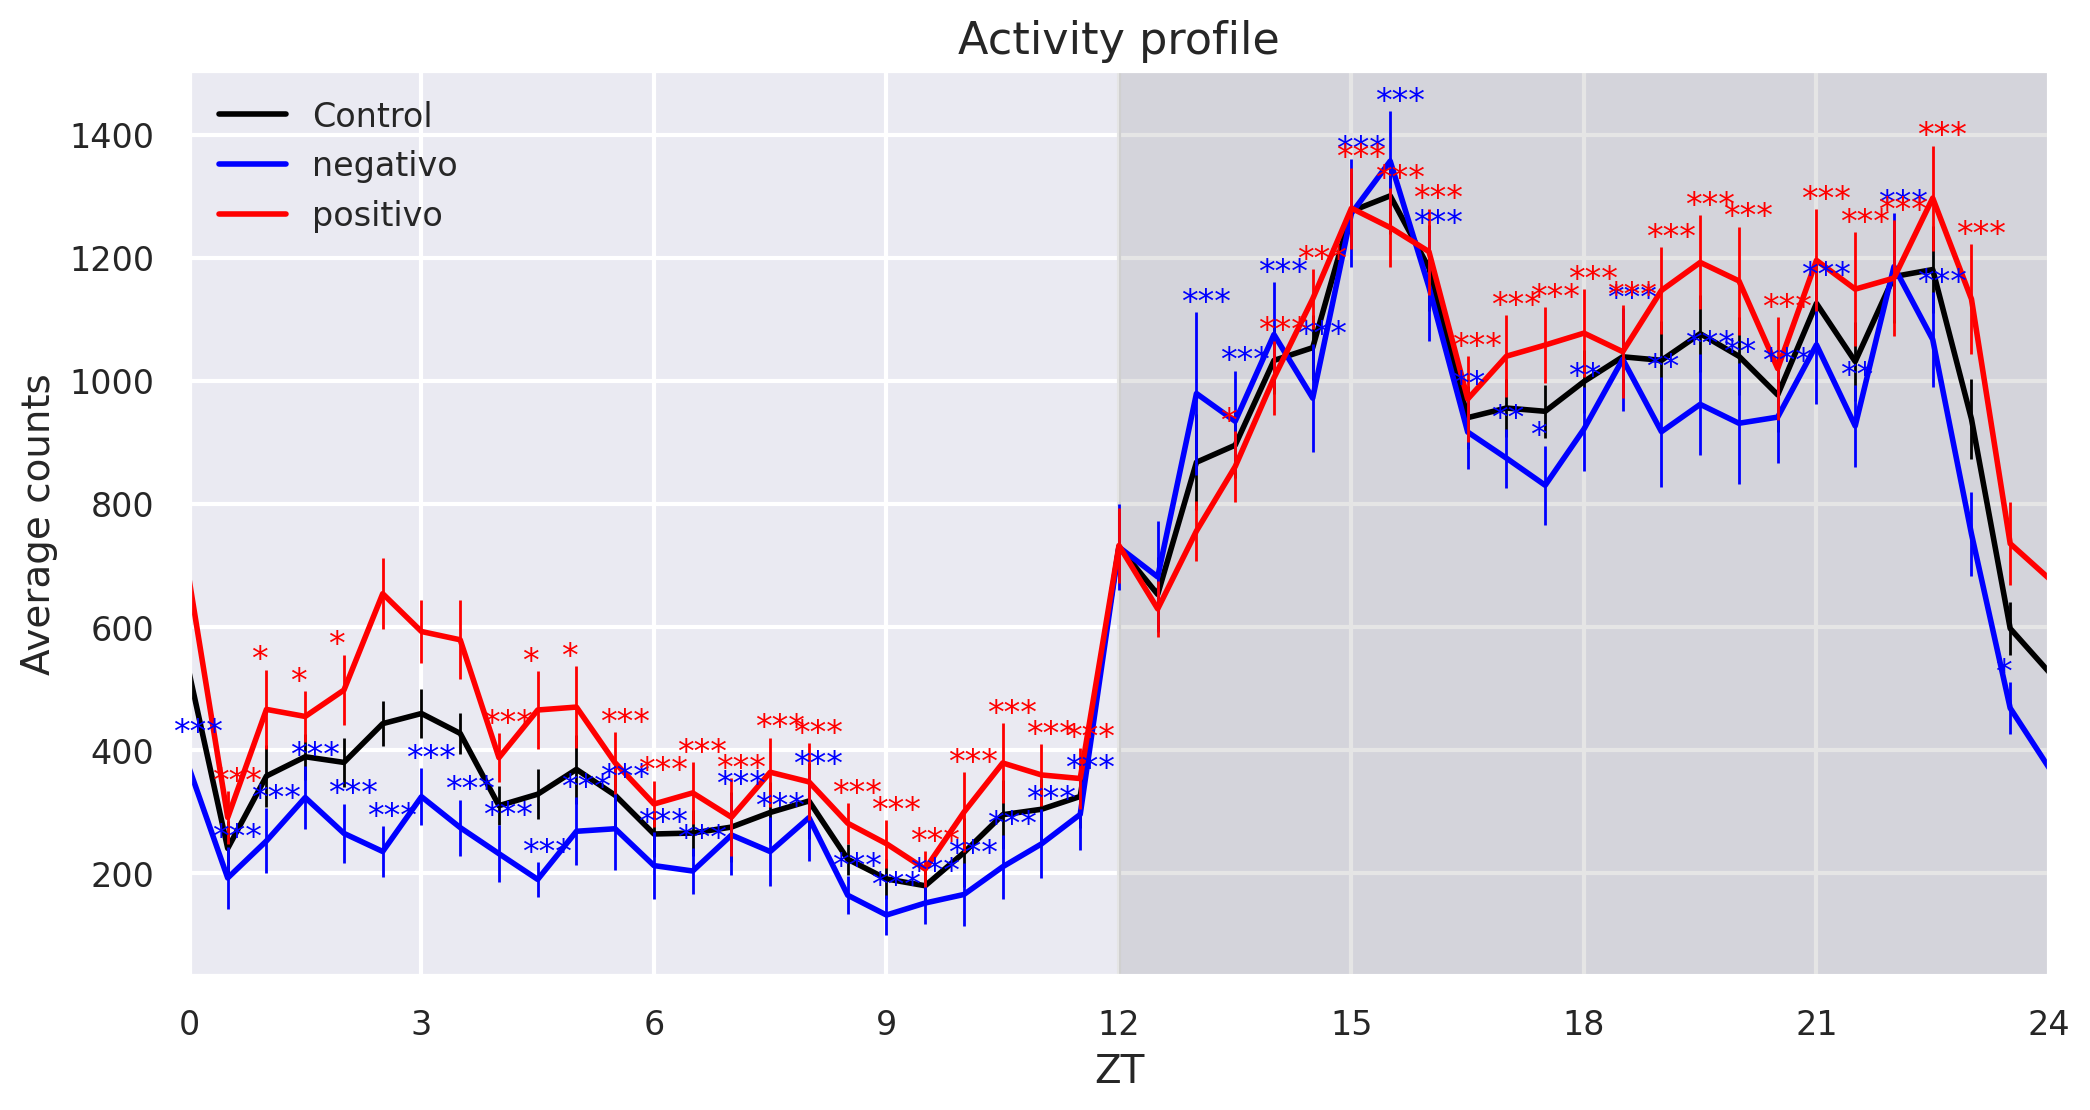

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import ttest_ind

df = pd.read_excel('https://github.com/ZerchJaa/activity_lab_buijs/raw/519298871107ae79e9642a9e4db80dfbd543403a/ACTIVIDADES%20INICIO%20AL%2024%20de%20MARZO.xlsx')
df['Fecha'] = df['Fecha'].ffill().bfill()

def plot_activity_profile(controls, title, xlabel, ylabel, legend_labels):
    sns.set_style('darkgrid')

    # Aumenta el tamaño de la figura y la densidad de píxeles (DPI) al doble
    fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

    plt.xlabel(xlabel, fontsize=14)  # Aumenta el tamaño de la fuente del xlabel
    plt.ylabel(ylabel, fontsize=14)  # Aumenta el tamaño de la fuente del ylabel
    plt.xlim(0, 24)
    plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24], ['0', '3', '6', '9', '12', '15', '18', '21', '24'], fontsize=12)  # Aumenta el tamaño de la fuente de los ticks del eje X

    ax.axvspan(12, ax.get_xlim()[1], alpha=0.2, color='gray')
    ax.set_xticks(np.arange(1, 24), minor=True)
    ax.tick_params(axis='x', which='minor', direction='out', length=5, color='black')
    ax.tick_params(axis='x', which='major', direction='out', length=8, color='black')  # Aumenta el tamaño de los ticks mayores del eje X
    ax.tick_params(axis='y', labelsize=12)  # Aumenta el tamaño de la fuente de los ticks del eje Y

    control_columns, control_lb, control_ub, control_color, _ = controls[0]
    control_df = df.loc[(df['Muestreo'] >= control_lb) & (df['Muestreo'] <= control_ub)]
    control_averages = control_df[list(control_columns)].mean(axis=1)

    for control, legend_label in zip(controls, legend_labels):
        selected_columns, lower_bound, upper_bound, color, _ = control

        df['Promedio'] = df[list(selected_columns)].mean(axis=1)
        df_subset = df.loc[(df['Muestreo'] >= lower_bound) & (df['Muestreo'] <= upper_bound)]
        zt_stats = df_subset.groupby('ZT')['Promedio'].agg(['mean', 'sem'])
        zt_stats = zt_stats.sort_index()
        new_row = zt_stats.iloc[0].rename(24)
        zt_stats = pd.concat([zt_stats, new_row.to_frame().T])
        zt_means = zt_stats['mean'].values
        zt_sems = zt_stats['sem'].values

        ax.plot(zt_stats.index, zt_means, color=color, label=legend_label, linewidth=2)
        ax.vlines(zt_stats.index, zt_means - zt_sems, zt_means + zt_sems, color=color, linewidth=1)

        if color != control_color:
            for i, (mean, sem) in enumerate(zip(zt_means, zt_sems)):
                t_stat, p_val = ttest_ind(control_averages, df_subset[df_subset['ZT'] == zt_stats.index[i]]['Promedio'])

                if p_val < 0.001:
                    significance = '***'
                elif p_val < 0.01:
                    significance = '**'
                elif p_val < 0.05:
                    significance = '*'
                else:
                    significance = ''

                if significance:
                    ax.annotate(significance,
                                xy=(zt_stats.index[i], mean + sem),
                                xytext=(zt_stats.index[i] - 0.2, mean + sem + 0.01),
                                fontsize=12,
                                color=color)

    ax.set_title(title, fontsize=16)
    ax.legend(loc='upper left', fontsize=12)  # Aumenta el tamaño de la fuente de la leyenda
    plt.show()

def on_plot_button_click(button):
    clear_output(wait=True)

    display(title_widget)
    display(xlabel_widget)
    display(ylabel_widget)
    display(legend_widget)

    for column_selector, lower_bound, upper_bound, _, description in control_widgets:
        display(column_selector)
        display(lower_bound)
        display(upper_bound)
        print()

    display(plot_button)

    controls = [(column_selector.value, lower_bound.value, upper_bound.value, color, description)
                for column_selector, lower_bound, upper_bound, color, description in control_widgets]

    legend_labels = legend_widget.value.split(',')

    plot_activity_profile(controls, title_widget.value, xlabel_widget.value, ylabel_widget.value, legend_labels)

control_widgets = []
for i, (color, description) in enumerate([('black', 'Control'), ('blue', 'negativo'), ('red', 'positivo')]):
    column_selector = widgets.SelectMultiple(options=list(df.iloc[:, 6:14].columns), description=f"{description} Columns", rows=8)
    lower_bound = widgets.IntText(value=0, description=f'{description} Lower bound:')
    upper_bound = widgets.IntText(value=1632, description=f'{description} Upper bound:')
    control_widgets.append((column_selector, lower_bound, upper_bound, color, description))

title_widget = widgets.Text(value='Activity profile', description='Title:')
xlabel_widget = widgets.Text(value='ZT', description='X-axis label:')
ylabel_widget = widgets.Text(value='Average counts', description='Y-axis label:')
legend_widget = widgets.Text(value='Control,negativo,positivo', description='Legend labels:')

plot_button = widgets.Button(description="Plot")
plot_button.on_click(on_plot_button_click)

display(title_widget)
display(xlabel_widget)
display(ylabel_widget)
display(legend_widget)

for column_selector, lower_bound, upper_bound, _, description in control_widgets:
    display(column_selector)
    display(lower_bound)
    display(upper_bound)
    print()

display(plot_button)


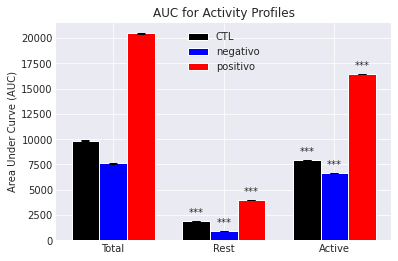

In [30]:
import numpy as np
from scipy.integrate import trapz
from sklearn.utils import resample
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt

def calculate_aucs_bootstrap_ttest(controls, intervals, n_points=1000, n_bootstrap=1000):
    auc_results = []
    p_values = []

    for control in controls:
        selected_columns, lower_bound, upper_bound, color, _ = control

        df['Promedio'] = df[list(selected_columns.value)].mean(axis=1)
        df_subset = df.loc[(df['Muestreo'] >= lower_bound.value) & (df['Muestreo'] <= upper_bound.value)]
        zt_stats = df_subset.groupby('ZT')['Promedio'].agg(['mean', 'sem'])
        zt_stats = zt_stats.sort_index()
        new_row = zt_stats.iloc[0].rename(24)
        zt_stats = pd.concat([zt_stats, new_row.to_frame().T])
        zt_means = zt_stats['mean'].values
        
        auc_values = []
        sem_values = []
        p_vals = []
        for interval in intervals:
            start, end = interval
            x = np.linspace(start, end, n_points)
            y = np.interp(x, zt_stats.index, zt_means)
            auc = trapz(y, x)

            # Bootstrap
            bootstrap_aucs = []
            for _ in range(n_bootstrap):
                resampled_y = resample(y, replace=True, random_state=None)
                bootstrap_auc = trapz(resampled_y, x)
                bootstrap_aucs.append(bootstrap_auc)

            sem = np.std(bootstrap_aucs, ddof=1) / np.sqrt(n_bootstrap)
            auc_values.append(auc)
            sem_values.append(sem)

            # T-test
            t_stat, p_val = ttest_ind(zt_means, y)
            p_vals.append(p_val)

        auc_results.append((auc_values, sem_values))
        p_values.append(p_vals)

    return auc_results, p_values

def plot_auc_bars(auc_results, p_values, legend_labels, colors):
    labels = ['Total', 'Rest', 'Active']
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots()
    for i, ((auc_values, sem_values), p_vals, legend_label, color) in enumerate(zip(auc_results, p_values, legend_labels, colors)):
        rects = ax.bar(x + (i-1) * width, auc_values, width, yerr=sem_values, capsize=4, label=legend_label, color=color)

        # Add significance asterisks
        for j, (rect, p_val) in enumerate(zip(rects, p_vals)):
            if p_val < 0.001:
                significance = '***'
            elif p_val < 0.01:
                significance = '**'
            elif p_val < 0.05:
                significance = '*'
            else:
                significance = ''

            if significance:
                ax.annotate(significance,
                            xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    ax.set_ylabel('Area Under Curve (AUC)')
    ax.set_title('AUC for Activity Profiles')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

intervals = [(0, 24), (0, 12), (12, 24)]
colors = ['black', 'blue', 'red']
legend_labels = legend_widget.value.split(',')

auc_results, p_values = calculate_aucs_bootstrap_ttest(control_widgets, intervals)
plot_auc_bars(auc_results, p_values, legend_labels, colors)
